<a href="https://colab.research.google.com/github/juampi20/artificial-intelligence-2022/blob/master/tp2_juanpablogarcia_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico N.°2

# Simple Linear Regression

## 1. Cargamos el dataset

In [50]:
!wget https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv -O datasets/insurance.csv

--2022-10-28 21:29:02--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolviendo raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Conectando con raw.githubusercontent.com (raw.githubusercontent.com)[185.199.111.133]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 54288 (53K) [text/plain]
Guardando como: “datasets/insurance.csv”

datasets/insurance. 100%[===================>]  53,02K   296KB/s    en 0,2s    

2022-10-28 21:29:03 (296 KB/s) - “datasets/insurance.csv” guardado [54288/54288]



In [51]:
import pandas as pd

# Cargamos el dataset
data = pd.read_csv("datasets/insurance.csv")

# Mostramos las primeras 5 filas
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [52]:
# Eliminamos las columnas no numericas
data.drop(columns=['sex', 'smoker', 'region'], inplace=True, axis=1)
data.head(5)

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


## 2. Elegimos una sola variable

En mi caso, voy a elegir solo `age` como variable **X** y voy a intentar modelar la relación con `bmi`, es decir, esta va a ser la variable **Y**.

In [53]:
x = data['age'].to_numpy() # Seleccionamos solo la columna "age" como datos de la variable independiente X
y = data['bmi'].to_numpy() # Seleccionamos la columna "bmi" como datos para supervisar el entrenamiento

## 3. Analizamos el dataset

Para esto analizaremos las siguientes características:

1. Normalidad de los datos.
2. Como se distribuyen.
3. Correlación

In [54]:
# Normalidad la calculamos usando el test de Shapiro-Wilk
from scipy.stats import shapiro
normalidad_x = shapiro(x)
normalidad_y = shapiro(y)

print(f"Normalidad de X: {normalidad_x}")
print(f"Normalidad de Y: {normalidad_y}")

Normalidad de X: ShapiroResult(statistic=0.9446989893913269, pvalue=5.687060076887153e-22)
Normalidad de Y: ShapiroResult(statistic=0.9938861727714539, pvalue=2.6033414542325772e-05)


> **Nota:** vemos que para ambos conjuntos de datos X e Y, el p-value es < 0.05 por lo cual se rechaza la hipotesis nula (H0) de que se distribuyen de forma normal. Habría que analizar que "otra forma de distribución pueden tener". Al saber que no se distribuyen de forma normal no se puede hacer un test de correlación de Pearson, pero si tal vez de Kendall...

Vemos como se distribuyen ambos conjuntos de datos X e Y

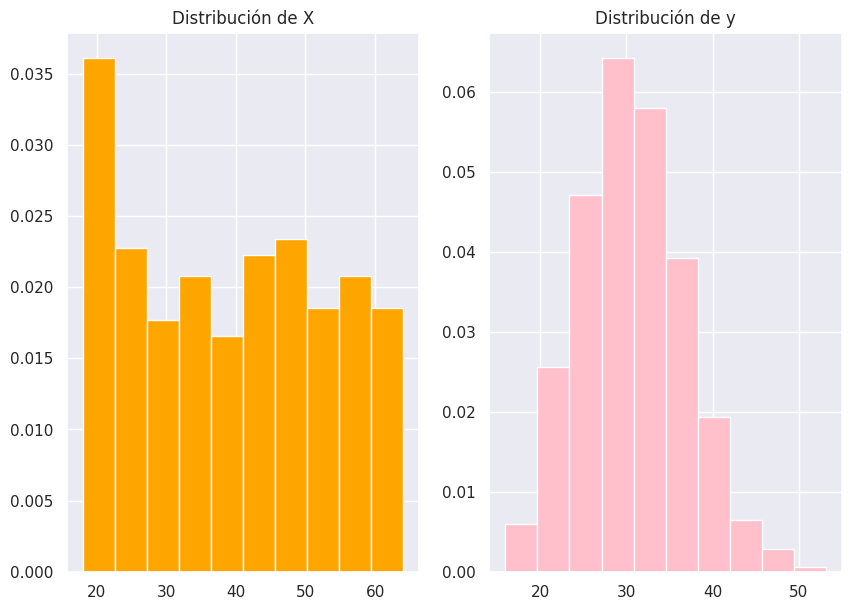

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.hist(x,color='orange',density=True)
plt.title("Distribución de X")
plt.subplot(1,2,2)
plt.hist(y,color='pink',density=True)
plt.title("Distribución de y");

Analizamos si se correlacionan a traves de una grafica de **scatter plot** o un **mapa de calor** o un **pairplot**.

Ya que no se distribuyen de forma normal, usaremos un test de correlacion de **Kendall**.

Text(0.5, 1.0, 'Mapa de calor de correlación entre ambas variables')

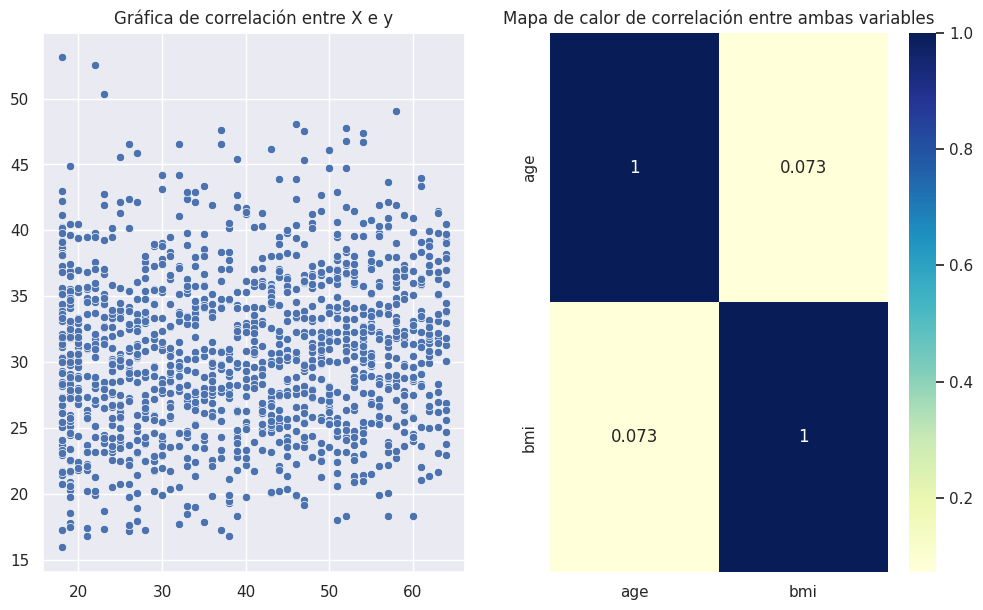

In [56]:
import seaborn as sns

sns.set()

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
sns.scatterplot(x=x, y=y)
plt.title("Gráfica de correlación entre X e y")
plt.subplot(1,2,2)
sns.heatmap(data[["age","bmi"]].corr(method='kendall'), cmap='YlGnBu', annot=True)
plt.title("Mapa de calor de correlación entre ambas variables")

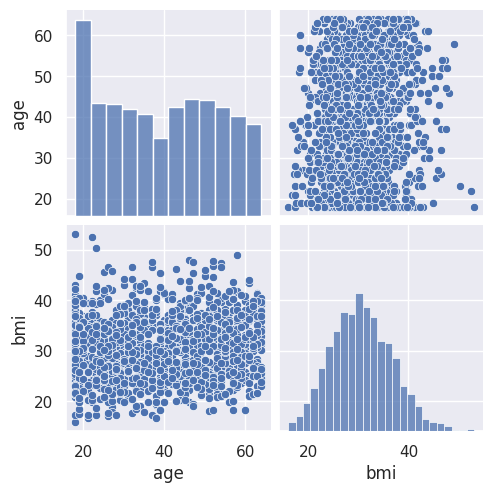

In [57]:
# Luego hacemos un pairplot
sns.pairplot(data[["age","bmi"]]);

> **Nota:** Este analisis de correlacion nos muestra que graficamente tanto en `scatterplot` como en `pairplot` podemos ver que entre las dos variables no logran una orientacion lineal. Por otro lado, el mapa de calor nos muestra el `valor` de la correlacion entre las variables que es de 0.073, lo que es bastante bajo. Llegados a este analisis, podemos concluir que, entre estas variables, no existe correlacion alguna ya que los datos estan muy distribuidos y el valor de la correlacion es muy cercana a cero.